In [1]:
import numpy as np
import os
import cv2
from keras import layers
import string
print(os.listdir('../Dataset/captcha-version-2-images'))

['samples', 'Ab1eZ.jpg', 'abcde.jpg', 'Pqr1g.jpg']


Using TensorFlow backend.


Symbols contains the letters possible in images.
Dataset contains 1070 images  of shape 50*200*1

In [2]:
Symbols = string.ascii_lowercase + string.ascii_uppercase + "0123456789"
num_Symbols = len(Symbols)
print('Number of symbols to be considered ', num_Symbols)
img_shape = (50, 200, 1)


Number of symbols to be considered  62


In [3]:
def data_pre_processing():
    num_samples = len(os.listdir('../Dataset/captcha-version-2-images/samples'))
    print('Number of images ', num_samples)
    X = np.zeros((num_samples, 50, 200,1))                    # 1070*50*200*1
    Y = np.zeros((num_samples, 5, num_Symbols))               # 1070*5*62
    
    for i, pic in enumerate(os.listdir('../Dataset/captcha-version-2-images/samples')):
        
        # i is used as enumerating index
        # pic contains the name of image e.g. "name".png
        img = cv2.imread(os.path.join('../Dataset/captcha-version-2-images/samples', pic), cv2.IMREAD_GRAYSCALE)
        
        name_of_image = pic[:-4]
        
            
        # scaling and resizing the image
        img = img/255
        img = cv2.resize(img,(50,200))
        img = np.reshape(img,(50,200,1))
            
        # define a matrix to mark all the characters present in image as 1 and rest all as 0
        chars = np.zeros((5,num_Symbols))
            
        for index in range(0, len(name_of_image)):
            l = Symbols.find(name_of_image[index])
            chars[index, l] = 1
            
        X[i] = img
        Y[i] = chars
            
    return X, Y

# X contains the images and Y their labels 
# i.e. X[i] has the image then Y[i] has its characters


X, Y = data_pre_processing()

# divide the dataset into test and train dataset
# out of 1070 images we will take 900 as training images and 170 as test images
    
X_train, Y_train = X[:900], Y[:900]
X_test, Y_test = X[900:], Y[900:]
print("Size of training dataset(images and labels) ", X_train.shape, Y_train.shape)
print("Size of testing dataset(images and labels) ", X_test.shape, Y_test.shape)

Number of images  1070
Size of training dataset(images and labels)  (900, 50, 200, 1) (900, 5, 62)
Size of testing dataset(images and labels)  (170, 50, 200, 1) (170, 5, 62)



Now we define and create the model:<br>
The model will be sequential then Conv and dense layers.<br>
<br>
Some models used and their respective losses<br>
((CONV(RELU)->DROP)*2->POOL)*2->(FC(RELU)->DROP)*3  (32 filters used in Conv2D)--> getting approx 21% loss <br>
((CONV(RELU)->DROP)->POOL)*2->(FC(RELU)->DROP)*3    (32 filters used in Conv2D)--> getting approx 12% loss<br>
((CONV(RELU)->DROP)->POOL)->(FC(RELU)->DROP)*3      (32 filters used in Conv2D)--> getting approx 11% loss <br>
((CONV(RELU)->DROP)*3->POOL)->(FC(RELU)->DROP)*2    (16 filters used in Conv2D)--> getting approx 9% loss  <br>
((CONV(RELU))->POOL)*3->CONV(RELU)->BN->POOL->(FC(RELU)*2)    --> 7% loss <br>


In [4]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, InputLayer, BatchNormalization


def create_model():
    
    # define sequential model
    model = Sequential()
    
    # 16 filter each with (3,3) size, stride =1 and same padding, relu activation 
    # specify input shape which is done only in first layer rest all layers take care of it automatically 
    model.add(InputLayer(input_shape=img_shape))
    model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=img_shape))
    # max pool with pool size = 2 and strides = 2 will discard 75% activations
    model.add(MaxPool2D(padding='same'))
    model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D(padding='same'))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D(padding='same'))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(padding='same'))
    
    # now flatten the model and split into 5 branches 
    # each branch will predict one letter in image
    model.add(Flatten())
    outs = []
    for i in range(0, 5):
        temp = model.layers[len(model.layers)-1].output
        temp1 = layers.Dense(64, activation='relu')(temp)
        temp2 = layers.Dense(num_Symbols, activation='sigmoid')(temp1)
        outs.append(temp2)
        
    # making a new model with input as the one in previous and output as outs layer
    model = Model(inputs=model.input, outputs=outs)
    
    # visualize the architecture of model
    model.summary()
    
    # compile the model using 
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
    return model




Creating the model and training it 


In [5]:
model = create_model()
hist = model.fit(X_train,[Y_train[:,0,:],Y_train[:,1,:],Y_train[:,2,:],Y_train[:,3,:],Y_train[:,4,:]],batch_size=32, epochs=30, verbose=1, validation_split=0.2)


W0721 09:44:26.033747 140285584717632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0721 09:44:26.051581 140285584717632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0721 09:44:26.054810 140285584717632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0721 09:44:26.081586 140285584717632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0721 09:44:26.183108 140285584717632 deprecation_wrapp

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 200, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 200, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 25, 100, 16)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 25, 100, 16)  2320        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

Evaluating the model to get loss % and accuracy for test data



In [6]:
score = model.evaluate(X_test,[Y_test[:,0,:],Y_test[:,1,:],Y_test[:,2,:],Y_test[:,3,:],Y_test[:,4,:]],batch_size=50,verbose=0)
for i in range(0,len(model.metrics_names)):
    print(model.metrics_names[i],"  ",score[i])
    

loss    7.70819304971134
dense_2_loss    1.03501655774958
dense_4_loss    2.2033313162186565
dense_6_loss    1.7757245652815874
dense_8_loss    1.842155982466305
dense_10_loss    0.851964393082787
dense_2_acc    0.7705882296842688
dense_4_acc    0.5352941190495211
dense_6_acc    0.6058823711731854
dense_8_acc    0.6117647009737351
dense_10_acc    0.7411764719906975


predict function to predict the characters in the image



In [7]:

def predict(file_path):
    img = cv2.imread(file_path,cv2.IMREAD_GRAYSCALE)
    
    if img is not None:
        img = img/255
        img = cv2.resize(img, (50,200))
        img = np.reshape(img,(50,200,1))
        img = img[np.newaxis,:,:,:]
    else :
        print("Not an image!")
    
    res = np.array(model.predict(img))
    res = res.reshape(5,num_Symbols)
    max_prob_indices = np.argmax(res,1)
    ans =""
    for i in max_prob_indices:
        ans+=Symbols[i]
    print(ans)
    

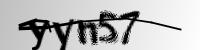

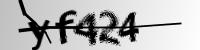

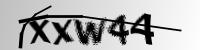

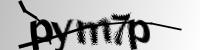

yyn57
yf424
xxw44
pym7p


In [10]:
from IPython.display import Image,display
display(Image(filename='../Dataset/captcha-version-2-images/samples/yyn57.png'))
display(Image(filename='../Dataset/captcha-version-2-images/samples/yf424.png'))
display(Image(filename='../Dataset/captcha-version-2-images/samples/xxw44.png'))
display(Image(filename='../Dataset/captcha-version-2-images/samples/pym7p.png'))
predict('../Dataset/captcha-version-2-images/samples/yyn57.png')
predict('../Dataset/captcha-version-2-images/samples/yf424.png')
predict('../Dataset/captcha-version-2-images/samples/xxw44.png')
predict('../Dataset/captcha-version-2-images/samples/pym7p.png')
